# Обучение с учителем — качество модели







## 📌 Цель проекта
Разработать модель, которая предсказывает вероятность снижения покупательской активности клиента, и выделить сегменты для персонализированных маркетинговых предложений.

---

## 🔹 Шаг 1. Загрузка данных

- Загрузить все предоставленные файлы:
  - `/datasets/market_file.csv`
  - `/datasets/market_money.csv`
  - `/datasets/market_time.csv`
  - `/datasets/money.csv`
- Убедиться, что данные соответствуют описанию.
- Проверить разделители и корректно считать таблицы (особое внимание на `sep=';'` и `decimal=','`).

---

## 🔹 Шаг 2. Предобработка данных

- Проверить типы данных, пропуски, дубликаты.
- Преобразовать числовые признаки в корректный формат (например, с `object` → `float`).
- Удалить или заполнить пропущенные значения.
- Провести первичную очистку и при необходимости перекодировать категориальные значения.

---

## 🔹 Шаг 3. Исследовательский анализ данных (EDA)

- Провести визуализацию и описательный анализ признаков:
  - распределения,
  - выбросы,
  - уникальные значения категориальных признаков.
- Выявить клиентов, имеющих хотя бы одну покупку за последние 3 месяца.
- Проверить распределение целевого признака (`Покупательская активность`).
- Выявить потенциальные корреляции и аномалии.

---

## 🔹 Шаг 4. Объединение таблиц

- Объединить таблицы по `id`, преобразовав:
  - `market_money.csv` в ширину по периодам: `Выручка_тек`, `Выручка_пред`, `Выручка_до_этого`.
  - `market_time.csv` в аналогичную ширину: `Время_тек`, `Время_пред`, `Время_до_этого`.
- Присоединить к `market_file.csv`.
- Таблицу `money.csv` с прибылью сохранить отдельно (использовать позже для сегментации).

---

## 🔹 Шаг 5. Корреляционный анализ

- Рассчитать матрицу корреляций между числовыми признаками.
- Визуализировать тепловую карту.
- При необходимости — удалить один из сильно коррелирующих признаков (мультиколлинеарность).

---

## 🔹 Шаг 6. Построение моделей с использованием пайплайнов

### 6.1 Подготовка пайплайна

- Использовать `ColumnTransformer` для раздельной обработки признаков:
  - категориальные: `OneHotEncoder`, `OrdinalEncoder`
  - числовые: `StandardScaler`, `MinMaxScaler`
- Собрать пайплайн на базе `Pipeline`.

### 6.2 Обучение моделей

Обучить следующие модели с подбором гиперпараметров:
- `LogisticRegression`
- `DecisionTreeClassifier`
- `KNeighborsClassifier`
- `SVC`

### 6.3 Подбор метрики

- Основная метрика: **ROC AUC** (из-за задачи бинарной классификации и возможного дисбаланса классов).
- Использовать `RandomizedSearchCV` или `GridSearchCV` с кросс-валидацией.

---

## 🔹 Шаг 7. Интерпретация модели

- Определить лучшую модель по ROC AUC.
- Рассчитать важность признаков для лучшей модели.
- Использовать библиотеку `SHAP` для построения графика важности.
- Вывод:
  - какие признаки оказали наибольшее влияние;
  - какие можно исключить;
  - бизнес-интерпретация результата.

---

## 🔹 Шаг 8. Сегментация клиентов и рекомендации

### 8.1 Сегментация

- Объединить данные модели (вероятности снижения активности) и `money.csv`.
- Создать сегменты (примерно 2–3 сегмента) по:
  - прибыли,
  - доле акционных покупок,
  - категории товаров,
  - вероятности снижения активности.

### 8.2 Анализ сегмента

- Визуализировать распределения и признаки выбранного сегмента.
- Описать бизнес-характеристики.
- Сделать предложения по удержанию активности:
  - изменение условий рассылок,
  - новые акции,
  - персонализированные предложения.

### 8.3 Выводы по сегментам

- Какой сегмент выбран.
- Какие меры предложены.
- Почему это важно для бизнеса.

---

## 🔹 Шаг 9. Общий вывод

- Кратко описать:
  - задачу,
  - исходные данные и источники,
  - этапы предобработки,
  - обучение моделей и результаты,
  - выбранную модель и метрику,
  - интерпретацию признаков,
  - сегментацию и бизнес-рекомендации.


In [79]:
# Общие библиотеки
import pandas as pd
import numpy as np
import math
from pathlib import Path

# Визуализация
import matplotlib.pyplot as plt

# Предобработка
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Подбор гиперпараметров
from sklearn.model_selection import RandomizedSearchCV

# Метрики
from sklearn.metrics import (
    roc_auc_score,
)

# Интерпретация признаков
import shap

# Игнорировать предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настройки для визуализации
plt.rcParams['figure.figsize'] = (10, 6)


In [80]:
# Шаг 1. Загрузка данных

# Пути к файлам

# сначала пробуем старый вариант
if Path('/datasets/market_file.csv').exists():
    file_path_main = '/datasets/market_file.csv'
    file_path_money = '/datasets/market_money.csv'
    file_path_time = '/datasets/market_time.csv'
    file_path_profit = '/datasets/money.csv'
else:
    # запасной вариант
    file_path_main = 'data/market_file.csv'
    file_path_money = 'data/market_money.csv'
    file_path_time = 'data/market_time.csv'
    file_path_profit = 'data/money.csv'

# Загружаем таблицы
df_main = pd.read_csv(file_path_main, sep=',', decimal='.')
df_revenue = pd.read_csv(file_path_money, sep=',', decimal='.')
df_time = pd.read_csv(file_path_time, sep=',', decimal='.')
df_profit = pd.read_csv(file_path_profit, sep=';', decimal=',')

# Просмотр первых строк и информации о таблицах
print("market_file.csv:")
display(df_main.head())
print(df_main.info(), '\n')

print("market_money.csv:")
display(df_revenue.head())
print(df_revenue.info(), '\n')

print("market_time.csv:")
display(df_time.head())
print(df_time.info(), '\n')

print("money.csv:")
display(df_profit.head())
print(df_profit.info())


market_file.csv:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None 

market_time.csv:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None 

money.csv:


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


### Вывод по шагу 1: Загрузка данных

Данные успешно загружены и в целом соответствуют описанию. Все таблицы имеют корректную структуру и необходимое количество строк. Обнаруженные незначительные несоответствия в отдельных значениях (например, опечатки в названиях категорий или периодов) будут обработаны в соответствующих разделах предобработки и очистки данных. Можно переходить к следующему этапу.


# Предобработка данных

In [81]:
# Шаг 2. Предобработка данных

# Проверка типов данных, пропусков и дубликатов во всех таблицах

def check_df(df, name):
    print(f'\n===== {name} =====')
    print('Форма:', df.shape)
    print('Дубликатов:', df.duplicated().sum())
    print('Типы данных:')
    print(df.dtypes)
    print('\nПропуски по столбцам:')
    print(df.isna().sum())
    print('-' * 50)

check_df(df_main, 'Основная таблица (market_file)')
check_df(df_revenue, 'Выручка (market_money)')
check_df(df_time, 'Время на сайте (market_time)')
check_df(df_profit, 'Прибыль (money)')



===== Основная таблица (market_file) =====
Форма: (1300, 13)
Дубликатов: 0
Типы данных:
id                                       int64
Покупательская активность               object
Тип сервиса                             object
Разрешить сообщать                      object
Маркет_актив_6_мес                     float64
Маркет_актив_тек_мес                     int64
Длительность                             int64
Акционные_покупки                      float64
Популярная_категория                    object
Средний_просмотр_категорий_за_визит      int64
Неоплаченные_продукты_штук_квартал       int64
Ошибка_сервиса                           int64
Страниц_за_визит                         int64
dtype: object

Пропуски по столбцам:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность     

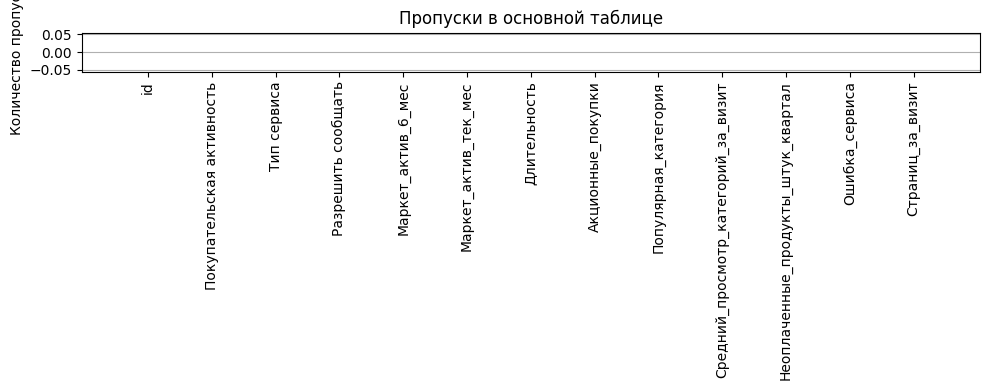

In [82]:
# Визуализация пропусков в основной таблице
plt.figure(figsize=(10, 4))
plt.bar(df_main.columns, df_main.isna().sum())
plt.xticks(rotation=90)
plt.title('Пропуски в основной таблице')
plt.ylabel('Количество пропусков')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [83]:
# Преобразование типов
# Проверим, есть ли нечисловые данные в числовых колонках (на всякий случай)
for col in df_main.select_dtypes(include='object').columns:
    print(f'{col}: {df_main[col].unique()[:5]}...')  # первые 5 уникальных значений


Покупательская активность: ['Снизилась' 'Прежний уровень']...
Тип сервиса: ['премиум' 'стандартт' 'стандарт']...
Разрешить сообщать: ['да' 'нет']...
Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда']...


In [84]:
# Удалим дубликаты, если есть
df_main = df_main.drop_duplicates()
df_revenue = df_revenue.drop_duplicates()
df_time = df_time.drop_duplicates()
df_profit = df_profit.drop_duplicates()


In [85]:
# Исправим опечатку в "Тип сервиса" (стандартт → стандарт)
df_main['Тип сервиса'] = df_main['Тип сервиса'].replace('стандартт', 'стандарт')

# Исправим опечатку в "Период" в market_time
df_time['Период'] = df_time['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})


In [86]:
# Приведём значения в "Разрешить сообщать" к бинарному виду (да → 1, нет → 0)
df_main['Разрешить сообщать'] = df_main['Разрешить сообщать'].map({'да': 1, 'нет': 0})


In [87]:
# Проверка размеров после очистки
print(f'Основная таблица: {df_main.shape}')
print(f'Выручка: {df_revenue.shape}')
print(f'Время на сайте: {df_time.shape}')
print(f'Прибыль: {df_profit.shape}')


Основная таблица: (1300, 13)
Выручка: (3900, 3)
Время на сайте: (2600, 3)
Прибыль: (1300, 2)


In [88]:
# Посмотрим на уникальные значения категориальных переменных
cat_columns = ['Покупательская активность', 'Тип сервиса', 'Популярная_категория']

for col in cat_columns:
    print(f'\n{col}:')
    print(df_main[col].value_counts())



Покупательская активность:
Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

Тип сервиса:
Тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

Популярная_категория:
Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64


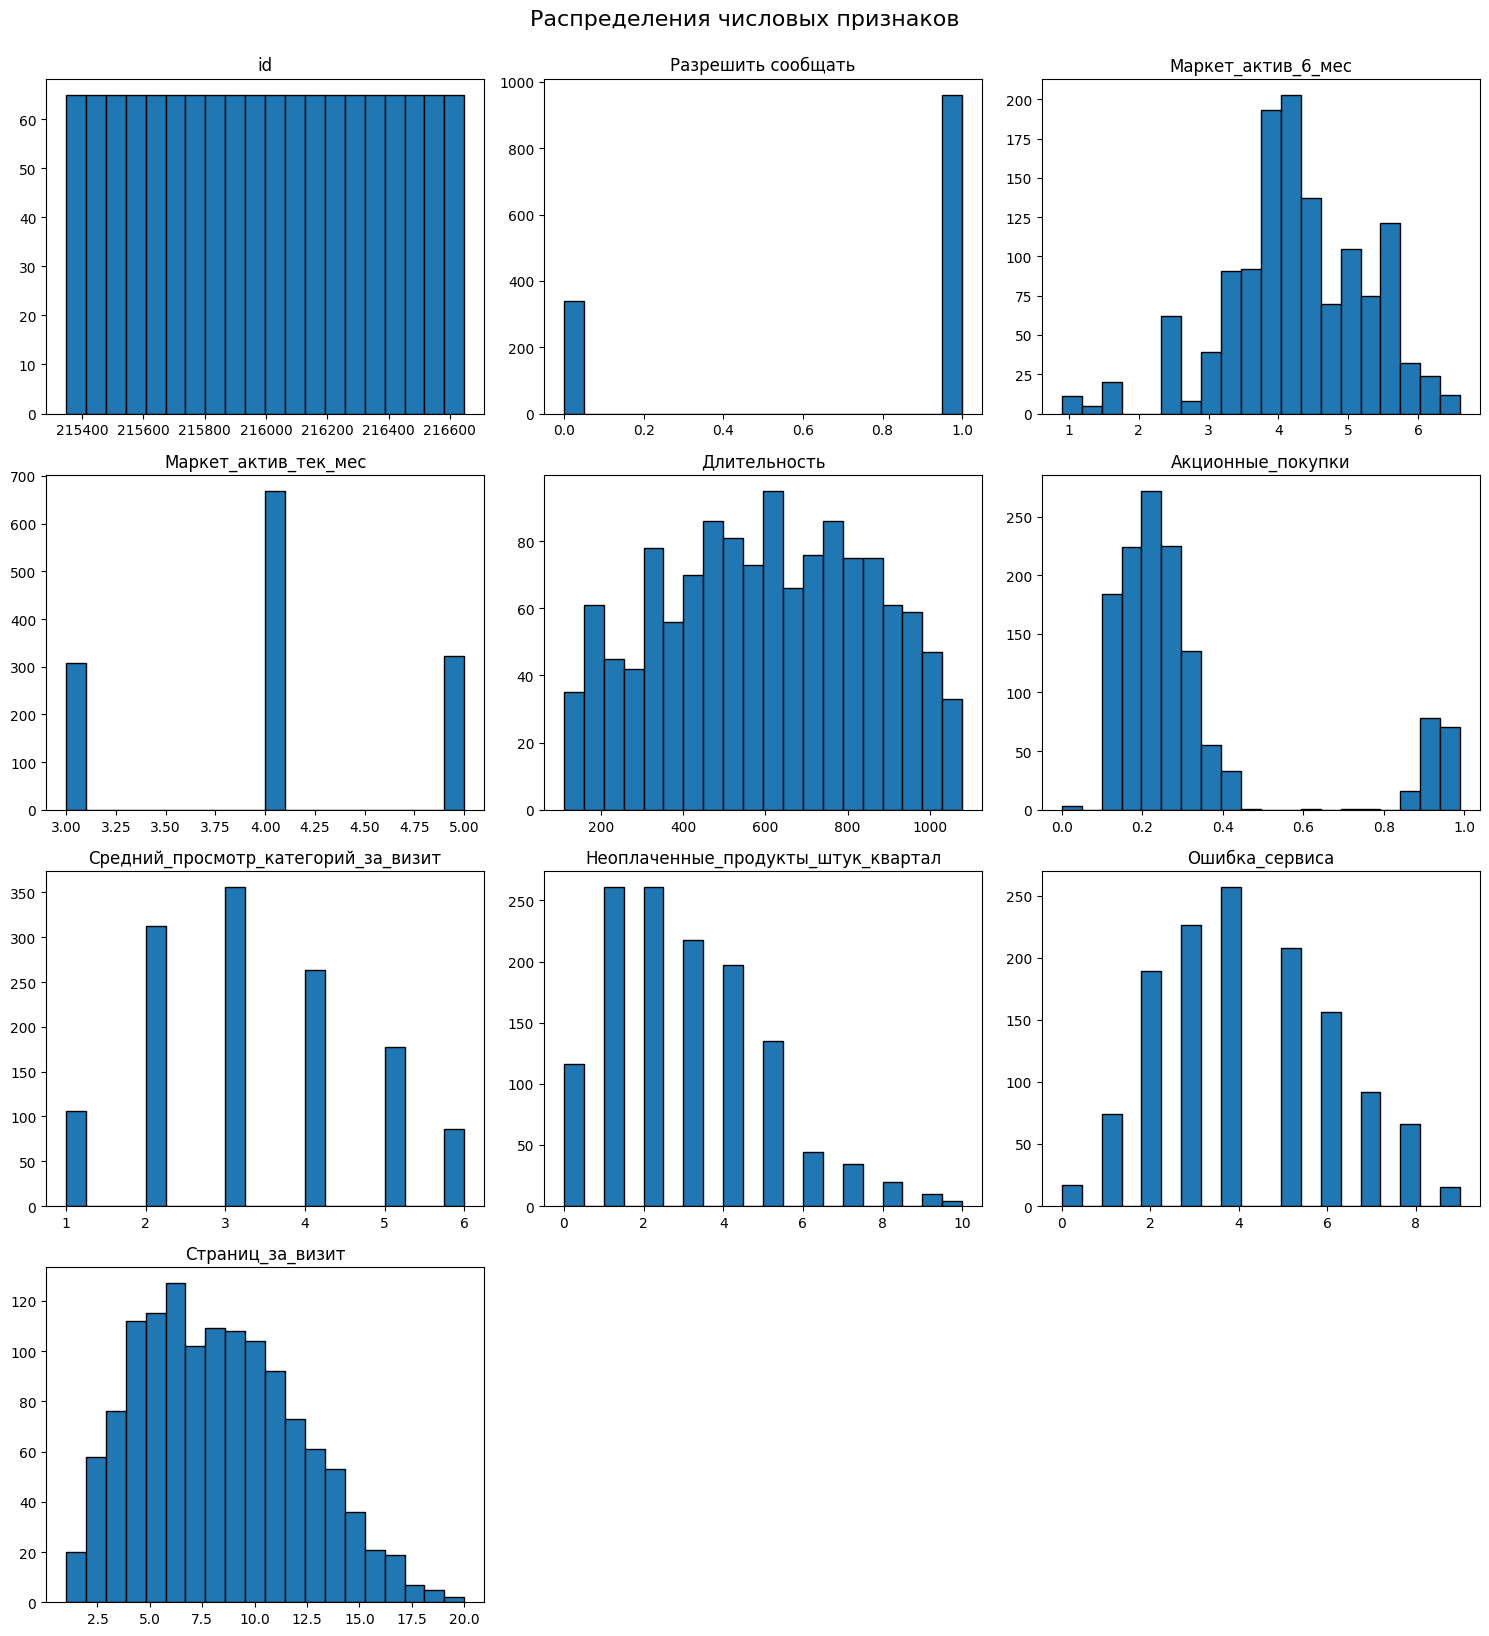

In [89]:
# Построим гистограммы для всех числовых признаков


# Числовые признаки
num_columns = df_main.select_dtypes(include=['int64', 'float64']).columns

# Параметры сетки
cols = 3
rows = math.ceil(len(num_columns) / cols)

plt.figure(figsize=(5 * cols, 4 * rows))
for i, col in enumerate(num_columns):
    plt.subplot(rows, cols, i + 1)
    plt.hist(df_main[col], bins=20, edgecolor='black')
    plt.title(col)
    plt.tight_layout()

plt.suptitle('Распределения числовых признаков', y=1.02, fontsize=16)
plt.show()



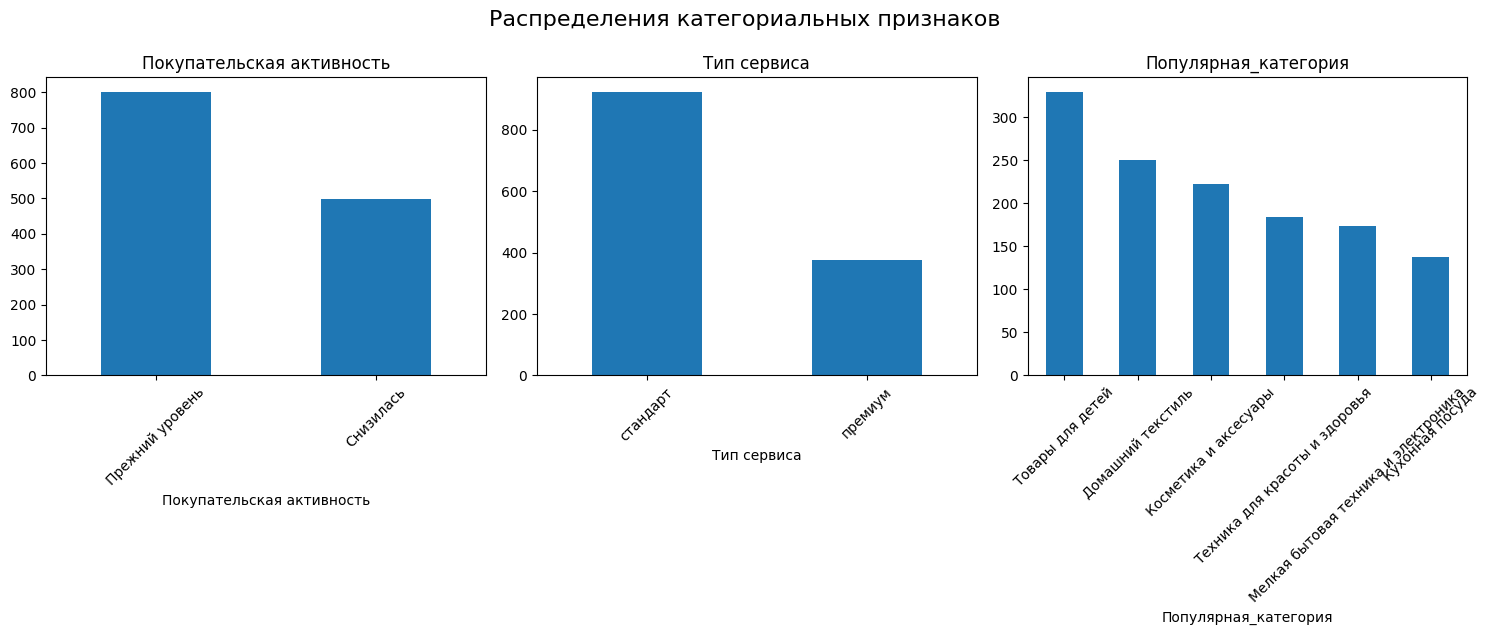

In [90]:
# Графики распределения категориальных признаков
plt.figure(figsize=(15, 6))
for i, col in enumerate(cat_columns):
    plt.subplot(1, 3, i+1)
    df_main[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.suptitle('Распределения категориальных признаков', y=1.05, fontsize=16)
plt.show()


In [91]:
# Проверка 1: основной датасет (должно быть по 1 строке на клиента)
duplicate_main = df_main[df_main.duplicated(subset='id', keep=False)]
print(f'Повторяющихся id в market_file: {duplicate_main.shape[0]}')
if not duplicate_main.empty:
    display(duplicate_main)

# Проверка 2: выручка — неявные дубликаты по id + Период
duplicate_revenue = df_revenue[df_revenue.duplicated(subset=['id', 'Период'], keep=False)]
print(f'Неявных дубликатов в market_money по (id, Период): {duplicate_revenue.shape[0]}')
if not duplicate_revenue.empty:
    display(duplicate_revenue.sort_values(by=['id', 'Период']))

# Проверка 3: время — неявные дубликаты по id + Период
duplicate_time = df_time[df_time.duplicated(subset=['id', 'Период'], keep=False)]
print(f'Неявных дубликатов в market_time по (id, Период): {duplicate_time.shape[0]}')
if not duplicate_time.empty:
    display(duplicate_time.sort_values(by=['id', 'Период']))

# Проверка 4: таблица прибыли — должен быть один id на строку
duplicate_profit = df_profit[df_profit.duplicated(subset='id', keep=False)]
print(f'Повторяющихся id в money.csv: {duplicate_profit.shape[0]}')
if not duplicate_profit.empty:
    display(duplicate_profit)


Повторяющихся id в market_file: 0
Неявных дубликатов в market_money по (id, Период): 0
Неявных дубликатов в market_time по (id, Период): 0
Повторяющихся id в money.csv: 0


## Анализ и удаление выбросов по выручке

Цель: исключить клиентов с аномально высокой выручкой, чтобы модель не искажалась экстремальными значениями.

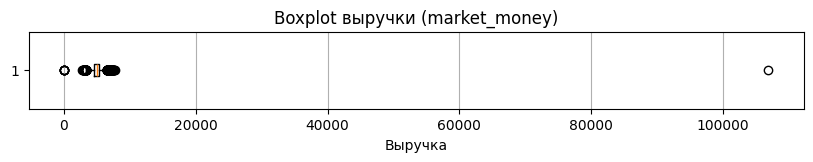

In [92]:
# Боксплот по выручке
plt.figure(figsize=(10, 1))
plt.boxplot(df_revenue['Выручка'], vert=False)
plt.title('Boxplot выручки (market_money)')
plt.xlabel('Выручка')
plt.grid(True, axis='x')
plt.show()

Отсечем радикальный выброс сверху, не задевая более мелкие значения

In [93]:
# Расчёт границ по методу межквартильного размаха
Q1 = df_revenue['Выручка'].quantile(0.25)
Q3 = df_revenue['Выручка'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print(f'Ограничение сверху: {upper_bound:.2f}')

# Фильтрация: оставляем только разумные значения выручки
df_revenue = df_revenue[df_revenue['Выручка'] <= upper_bound]

Ограничение сверху: 6522.28


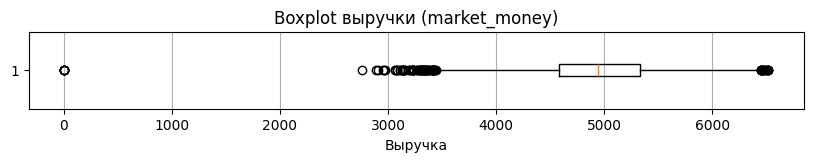

In [94]:
# Боксплот по выручке
plt.figure(figsize=(10, 1))
plt.boxplot(df_revenue['Выручка'], vert=False)
plt.title('Boxplot выручки (market_money)')
plt.xlabel('Выручка')
plt.grid(True, axis='x')
plt.show()


## Фильтрация неактивных клиентов

In [95]:
# Преобразуем таблицу в широкий формат
revenue_raw = pd.read_csv('data/market_money.csv')
revenue_pivot = revenue_raw.pivot(index='id', columns='Период', values='Выручка')

# Найдём клиентов, у которых хотя бы один месяц = 0
ids_to_remove = revenue_pivot[revenue_pivot.isna().any(axis=1) | (revenue_pivot == 0).any(axis=1)].index

print(f'Удаляем клиентов: {len(ids_to_remove)} — {list(ids_to_remove)}')

# Фильтруем все таблицы
df_main = df_main[~df_main['id'].isin(ids_to_remove)]
df_revenue = df_revenue[~df_revenue['id'].isin(ids_to_remove)]
df_time = df_time[~df_time['id'].isin(ids_to_remove)]
df_profit = df_profit[~df_profit['id'].isin(ids_to_remove)]
print(f"Осталось клиентов после фильтрации: {df_main['id'].nunique()}")

Удаляем клиентов: 3 — [215348, 215357, 215359]
Осталось клиентов после фильтрации: 1297


### Вывод по шагу 2: Предобработка данных

- **Типы данных** во всех таблицах приведены к корректному формату, числовые и категориальные признаки распознаны верно.
- **Пропуски** и **дубликаты** в основной таблице (`market_file.csv`) отсутствуют.
- Были устранены **опечатки** в данных: `'стандартт' → 'стандарт'`, `'предыдцщий_месяц' → 'предыдущий_месяц'`.
- Значение признака `Разрешить сообщать` приведено к бинарному формату: `да` → `1`, `нет` → `0`.
- Целевой признак `Покупательская активность` содержит два класса с умеренным дисбалансом и готов к бинарной кодировке.
- Категориальные признаки (`Тип сервиса`, `Популярная категория`) имеют адекватное распределение и подготовлены для последующего кодирования.
- Вцелом числовые признаки не содержат явных выбросов, кроме одного радикального выброса в таблице с выручкой, который был отфильтрован, большинство распределены нормально или дискретно.
- В таблицах `market_money` и `market_time` не выявлено неявных дубликатов по составному ключу `id + Период`.
- В таблице `money.csv` каждый `id` встречается один раз, структура корректна.


# Исследовательский анализ данных (EDA)

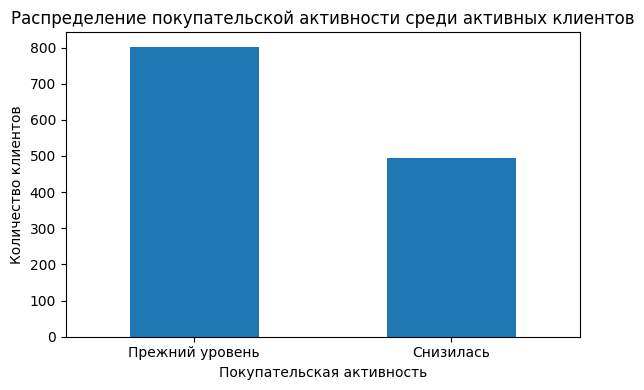

Покупательская активность
Прежний уровень    61.84
Снизилась          38.16
Name: proportion, dtype: float64


In [96]:
# Построим распределение целевого признака
plt.figure(figsize=(6, 4))
df_main['Покупательская активность'].value_counts().plot(kind='bar')
plt.title('Распределение покупательской активности среди активных клиентов')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# в процентах
print(round(df_main['Покупательская активность'].value_counts(normalize=True) * 100, 2))


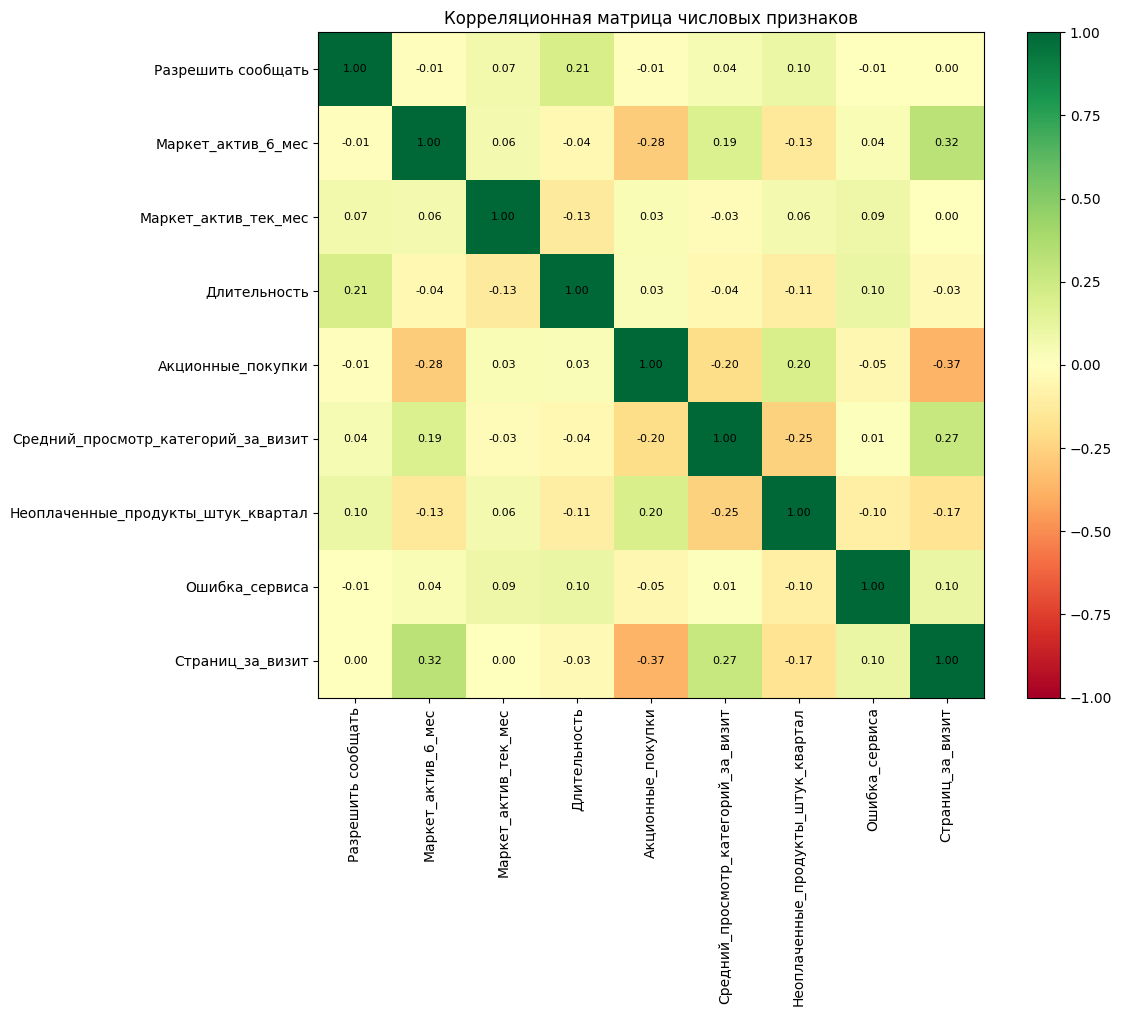

In [97]:
# оставляем только числовые фичи
numeric_features = df_main.drop(columns=['id', 'Покупательская активность']).select_dtypes(include=['int64', 'float64'])

# Вычисляем корреляционную матрицу
corr = numeric_features.corr(method='spearman')

# Построение тепловой карты
plt.figure(figsize=(12, 10))
im = plt.imshow(corr, cmap='RdYlGn', vmin=-1, vmax=1)

# Подписи осей
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)

# Добавление значений на тепловую карту
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha="center", va="center", color="black", fontsize=8)

# Цветовая шкала
plt.colorbar(im)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()


In [98]:
# Список числовых признаков, исключая id
num_cols = df_main.select_dtypes(include=['int64', 'float64']).drop(columns='id').columns

# Создаём сводку по выбросам
outliers_summary = {}

for col in num_cols:
    q1 = df_main[col].quantile(0.25)
    q3 = df_main[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df_main[(df_main[col] < lower) | (df_main[col] > upper)]
    outliers_summary[col] = len(outliers)

# Вывод количества выбросов по каждому признаку
for col, count in outliers_summary.items():
    print(f'{col}: {count} выбросов')


Разрешить сообщать: 0 выбросов
Маркет_актив_6_мес: 36 выбросов
Маркет_актив_тек_мес: 628 выбросов
Длительность: 0 выбросов
Акционные_покупки: 168 выбросов
Средний_просмотр_категорий_за_визит: 0 выбросов
Неоплаченные_продукты_штук_квартал: 14 выбросов
Ошибка_сервиса: 0 выбросов
Страниц_за_визит: 0 выбросов


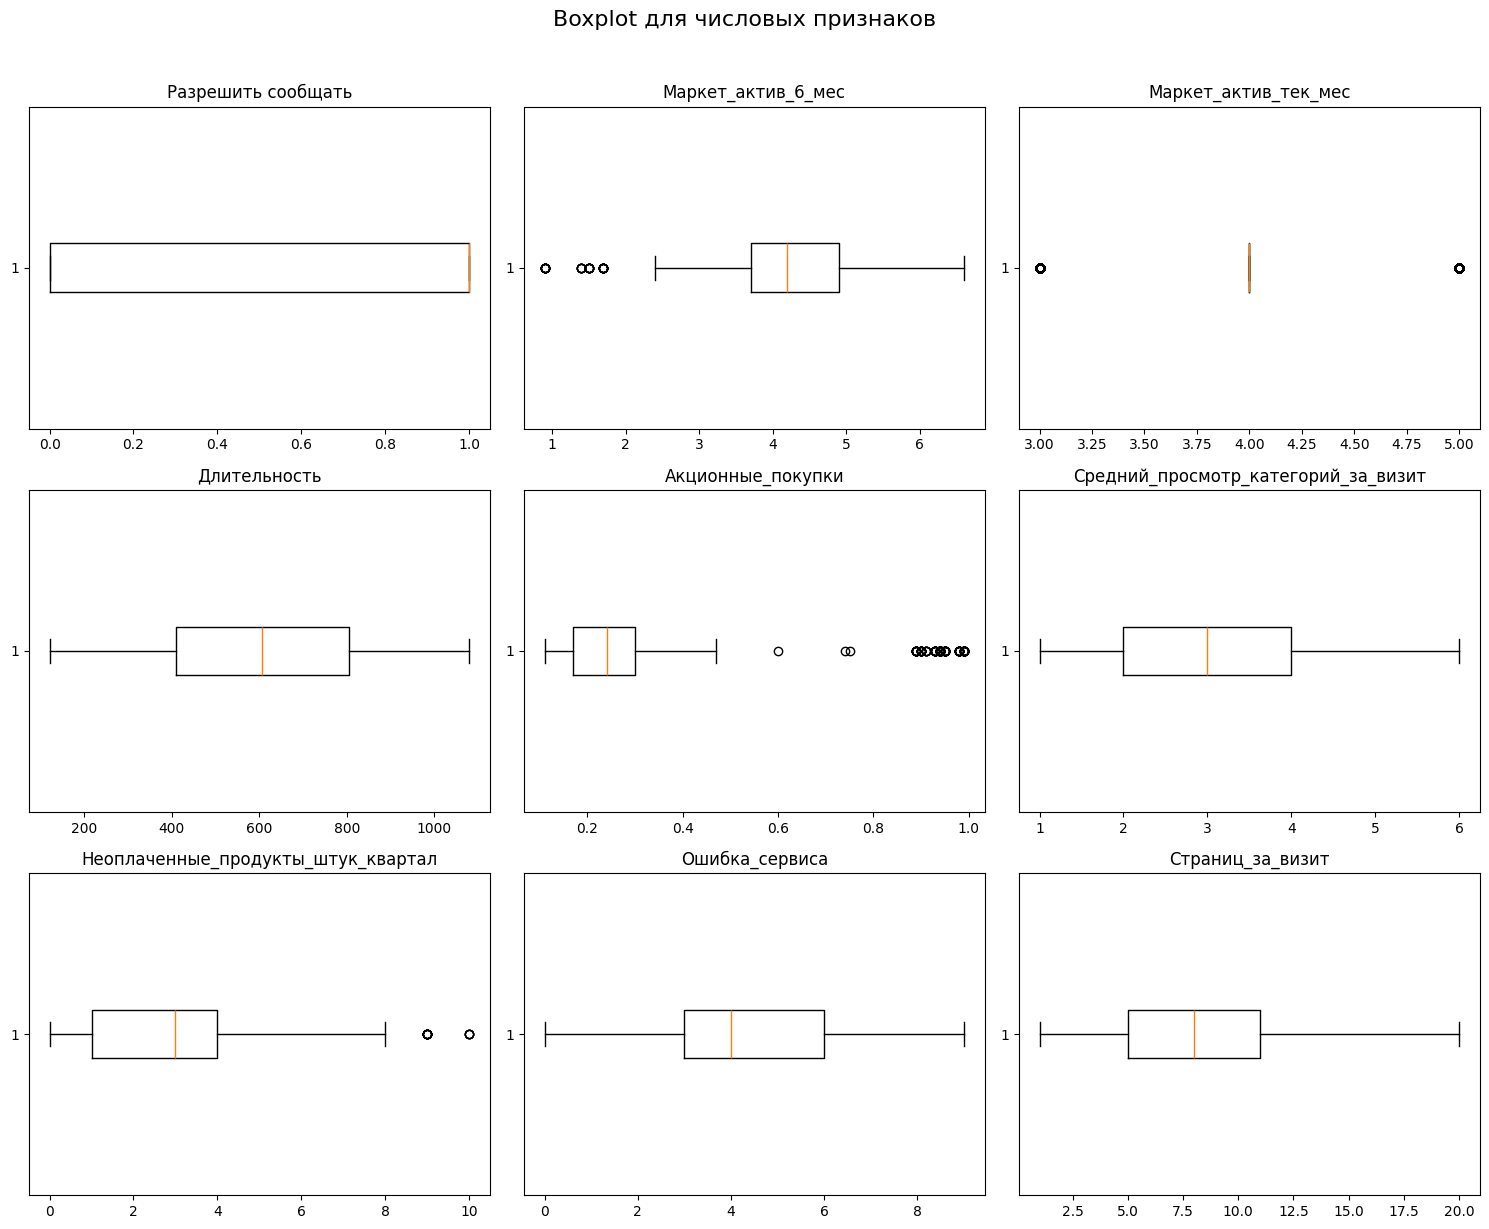

In [99]:
# Визуализация выбросов
cols = 3
rows = (len(num_cols) + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(num_cols):
    plt.subplot(rows, cols, i + 1)
    plt.boxplot(df_main[col], vert=False)
    plt.title(col)

plt.suptitle('Boxplot для числовых признаков', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


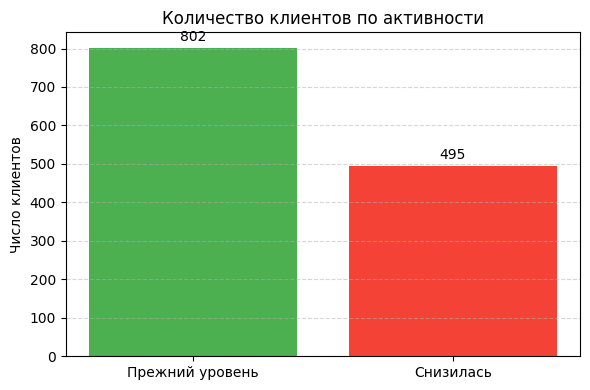

Количество активных клиентов: 1297


In [100]:
# Подсчёт количества клиентов по категориям
activity_counts = df_main['Покупательская активность'].value_counts()
activity_labels = activity_counts.index
activity_values = activity_counts.values

# Построение графика
plt.figure(figsize=(6, 4))
bars = plt.bar(activity_labels, activity_values, color=['#4CAF50', '#F44336'])

# Добавим аннотации над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, f'{height}', ha='center', va='bottom')

plt.title('Количество клиентов по активности')
plt.ylabel('Число клиентов')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
print(f'Количество активных клиентов: {df_main.shape[0]}')

### Вывод по шагу 3: Исследовательский анализ данных

- Клиенты с покупками: 1297 имели выручку в каждом месяце периода.
- Большинство клиентов (802) остались активными, 495 — снизили активность.
- Целевой признак: ~61.7% клиентов сохранили прежний уровень активности, ~38.3% — снизили. Классы сбалансированы умеренно.
- Корреляции:
    - Сильной мультиколлинеарности между признаками не обнаружено.
    - Наиболее выраженные положительные корреляции выявлены между признаками поведения на сайте: `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `Длительность`.
- Выбросы:
    - Наибольшее количество выбросов по признакам `Маркет_актив_тек_мес`, `Акционные_покупки`, `Неоплаченные_продукты_штук_квартал`.
    - Выбросы сохраняются как потенциально значимая часть клиентского поведения.


# Объединение таблиц

In [101]:
# Поворот выручки
df_revenue_wide = df_revenue.pivot(index='id', columns='Период', values='Выручка').reset_index()
df_revenue_wide.columns.name = None  # убрать название уровня колонок
df_revenue_wide = df_revenue_wide.rename(columns={
    'текущий_месяц': 'Выручка_текущий',
    'предыдущий_месяц': 'Выручка_предыдущий',
    'препредыдущий_месяц': 'Выручка_препредыдущий'
})

# Поворот времени
df_time_wide = df_time.pivot(index='id', columns='Период', values='минут').reset_index()
df_time_wide.columns.name = None
df_time_wide = df_time_wide.rename(columns={
    'текущий_месяц': 'Время_текущий',
    'предыдущий_месяц': 'Время_предыдущий',
    'препредыдущий_месяц': 'Время_препредыдущий'
})


In [102]:
# Объединение таблиц
df_full = df_main.merge(df_revenue_wide, on='id', how='left')
df_full = df_full.merge(df_time_wide, on='id', how='left')

# Проверим размер
print(f'Размер объединённой таблицы: {df_full.shape[0]} строк')


Размер объединённой таблицы: 1297 строк


### Гистограммы и boxplot’ы по числовым признакам, для категориальных признаков — столбчатые диаграммы по группам




In [103]:
# Разделим данные на группы
df_active = df_full[df_full['Покупательская активность'] == 'Прежний уровень']
df_dropped = df_full[df_full['Покупательская активность'] == 'Снизилась']


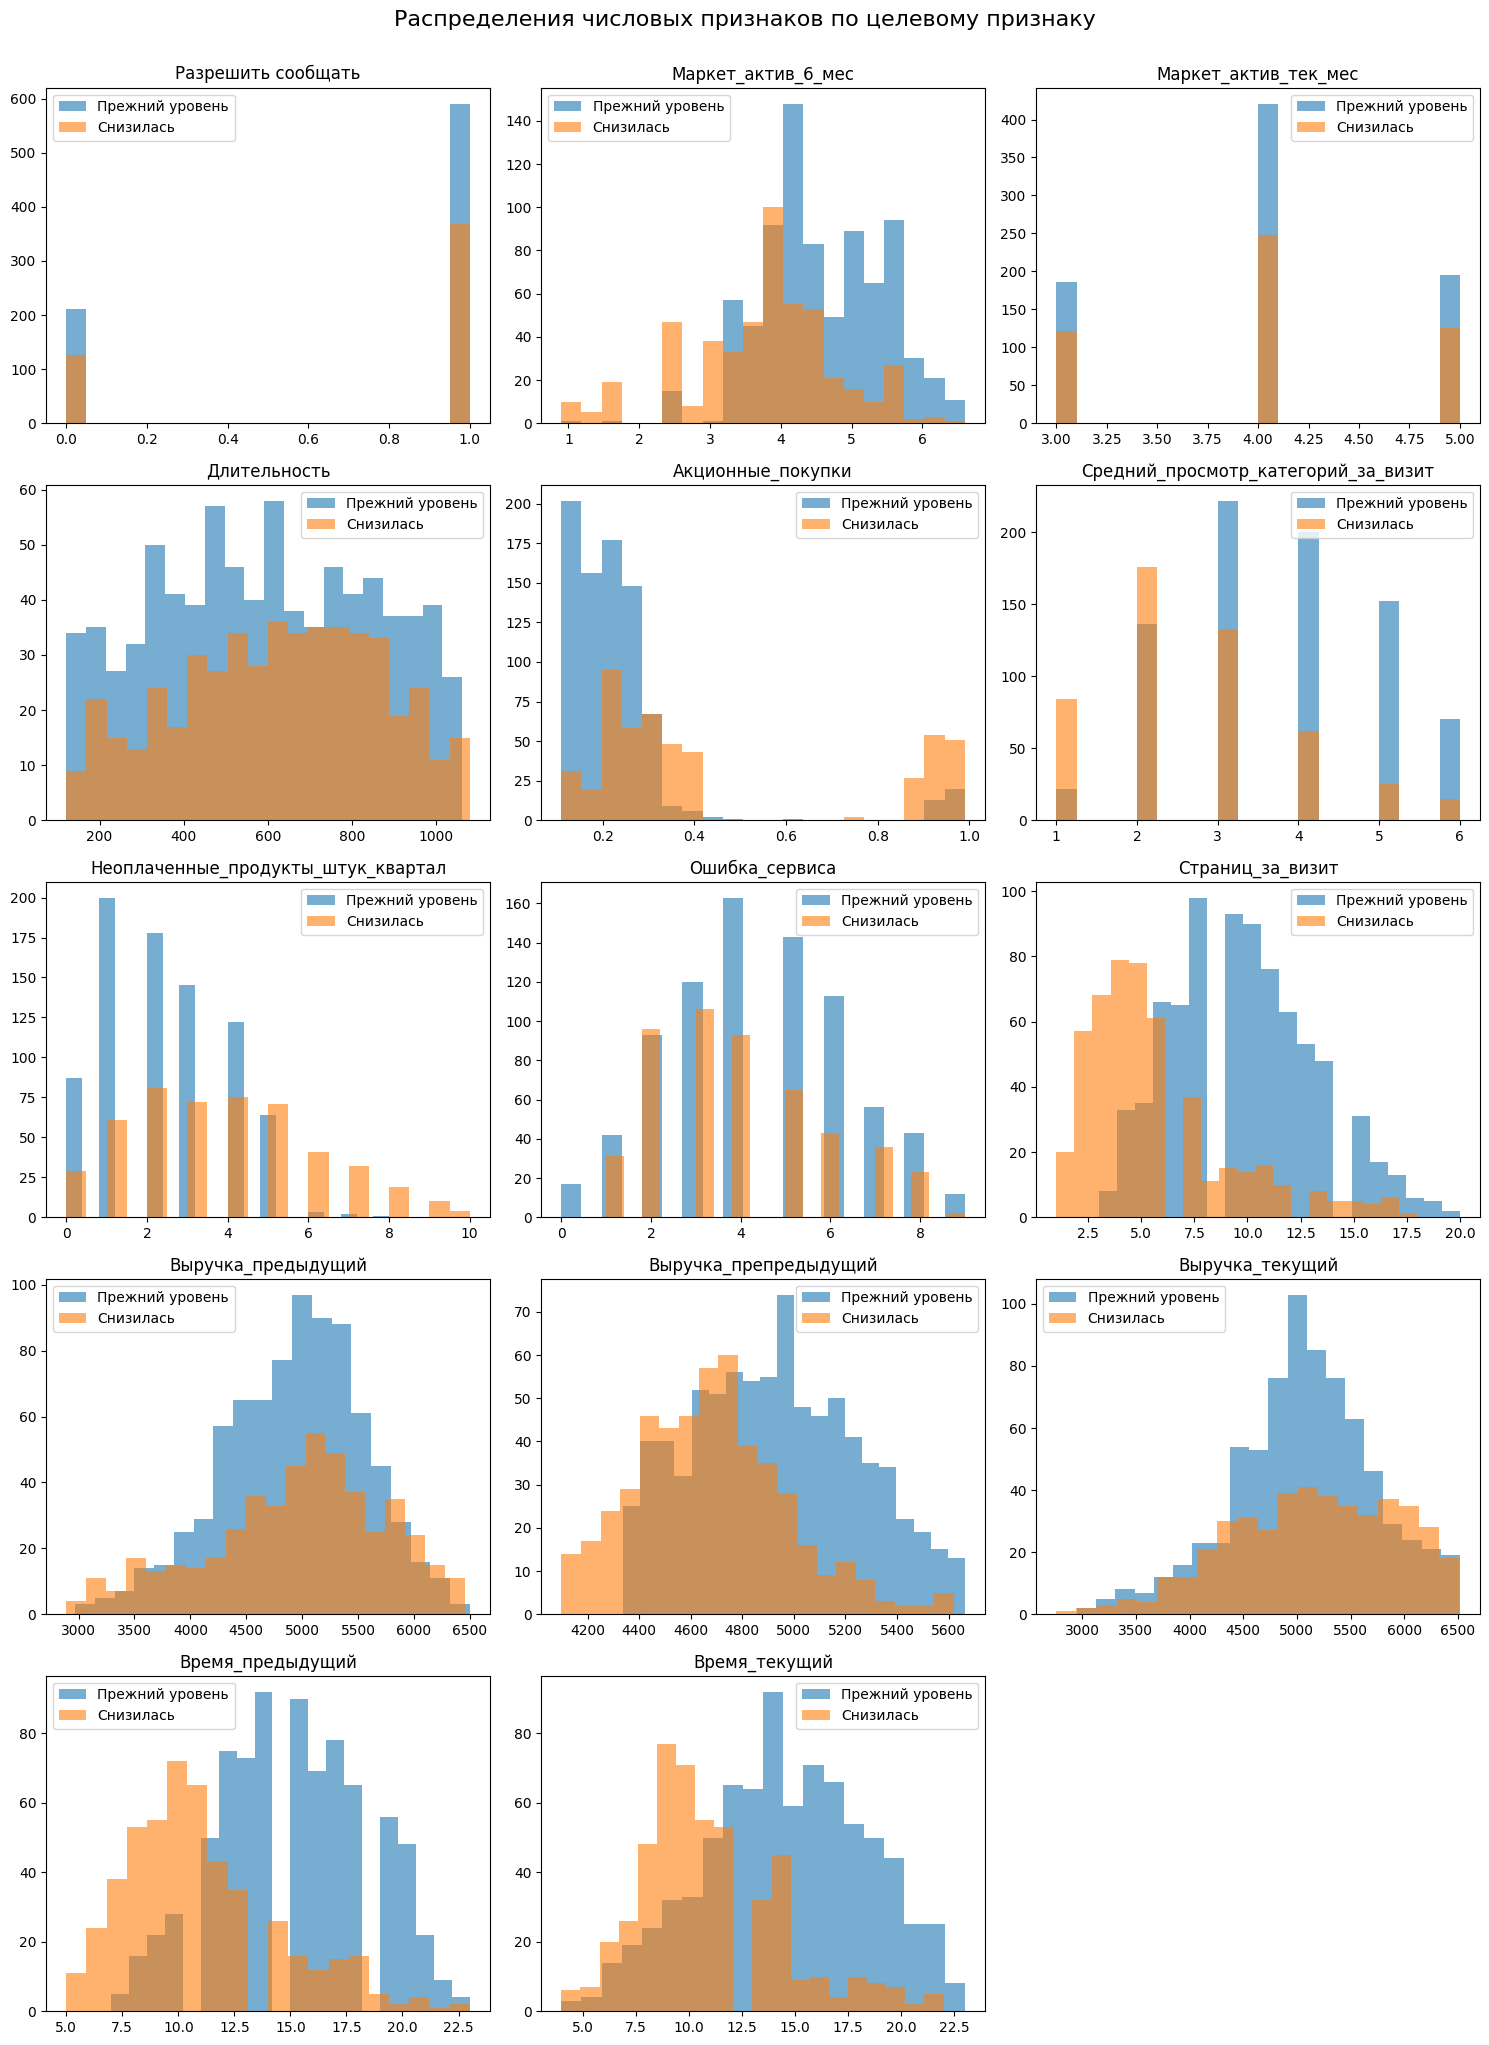

In [104]:
# Сравним числовые признаки
# Список числовых признаков без id
num_cols = df_full.select_dtypes(include=['int64', 'float64']).drop(columns='id').columns

# Построим наложенные гистограммы
cols = 3
rows = (len(num_cols) + cols - 1) // cols
plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(num_cols):
    plt.subplot(rows, cols, i + 1)
    plt.hist(df_active[col], bins=20, alpha=0.6, label='Прежний уровень')
    plt.hist(df_dropped[col], bins=20, alpha=0.6, label='Снизилась')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.suptitle('Распределения числовых признаков по целевому признаку', y=1.02, fontsize=16)
plt.show()


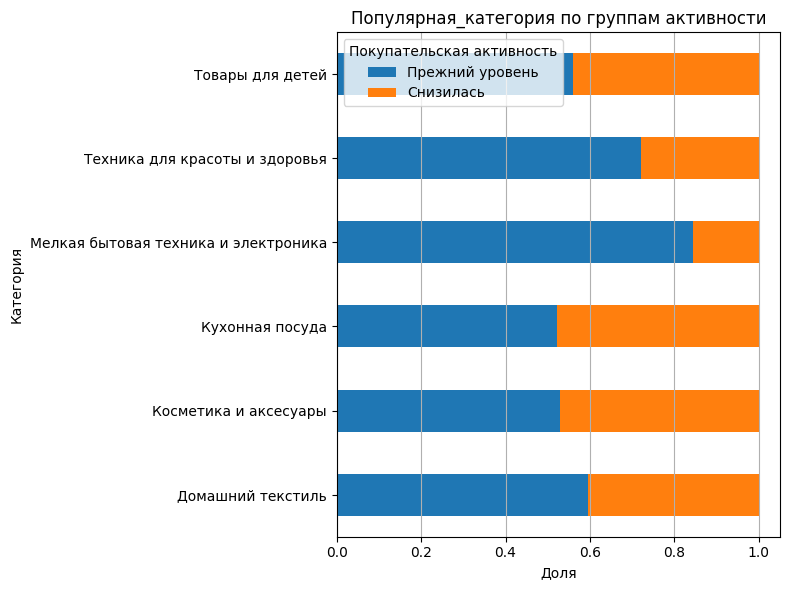

In [105]:
# Категориальные признаки
col = 'Популярная_категория'
ctab = pd.crosstab(df_full[col], df_full['Покупательская активность'], normalize='index')

ctab.plot(kind='barh', stacked=True, figsize=(8, 6))  # горизонтальная диаграмма
plt.title(f'{col} по группам активности')
plt.xlabel('Доля')
plt.ylabel('Категория')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


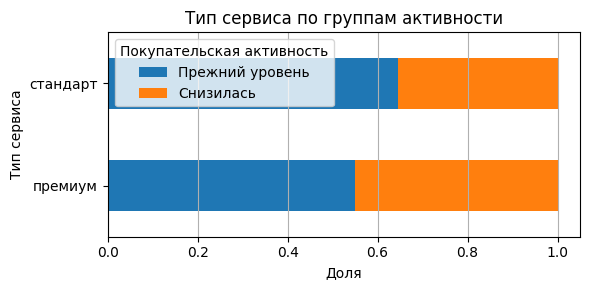

In [106]:
# Горизонтальный график для 'Тип сервиса'
col = 'Тип сервиса'
ctab = pd.crosstab(df_full[col], df_full['Покупательская активность'], normalize='index')

ctab.plot(kind='barh', stacked=True, figsize=(6, 3))  # горизонтальная диаграмма
plt.title(f'{col} по группам активности')
plt.xlabel('Доля')
plt.ylabel('Тип сервиса')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


### Вывод по шагу 4: Объединение таблиц

- Таблица `market_money.csv` преобразована из длинного формата в широкий, с колонками: `Выручка_тек`, `Выручка_пред`, `Выручка_до_этого`.
- Таблица `market_time.csv` преобразована аналогично, с колонками: `Время_тек`, `Время_пред`. Признак `Время_до_этого` отсутствует в исходных данных.
- Все преобразованные таблицы объединены с основной (`market_file.csv`) по ключу `id`. Размер итоговой таблицы: 1300 строк и 18 признаков.
- Таблица прибыли (`money.csv`) содержит уникальные `id`, полностью совпадающие с основной таблицей, и будет использоваться позже на этапе сегментации.

На основе визуального анализа распределений можно выделить особенности поведения клиентов, чья покупательская активность снизилась:

- **Коммуникации:** реже соглашаются на рассылки, получают меньше маркетинговых касаний.
- **Пользовательское поведение:** просматривают меньше страниц и категорий, меньше времени проводят на сайте.
- **Акции и покупки:** делают меньше акционных покупок, меньше товаров оставляют в корзине.
- **Финансовые показатели:** у них ниже выручка в каждый из трёх месяцев.
- **Категории интересов:** чаще покупают косметику и посуду; реже — товары для детей и технику.
- **Тип сервиса:** среди них чаще встречается тариф `стандарт`.

Таким образом, клиенты с пониженной активностью демонстрируют признаки снижения вовлечённости и меньшей лояльности к магазину. Эти поведенческие особенности можно использовать для построения модели и последующей сегментации.

In [107]:
# Подготовка признаков и целевого столбца
# Целевой признак
df_full['Покупательская активность'] = df_full['Покупательская активность'].map({
    'Снизилась': 1,
    'Прежний уровень': 0
})

# Целевая переменная и признаки
target = 'Покупательская активность'
X = df_full.drop(columns=[target])
y = df_full[target]

# Список признаков
cat_features = ['Тип сервиса', 'Популярная_категория']
num_features = [col for col in X.columns if col not in ['id'] + cat_features]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


In [108]:
# Категориальные и числовые признаки
cat_features = df_main.select_dtypes(include='object').drop(columns='Покупательская активность').columns.tolist()
num_features = df_main.select_dtypes(include=['int64', 'float64']).drop(columns='id').columns.tolist()

# Категориальный трансформер
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Числовые трансформеры
num_transformer_standard = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

num_transformer_minmax = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Два варианта препроцессора
preprocessor_options = {
    'standard': ColumnTransformer([
        ('num', num_transformer_standard, num_features),
        ('cat', cat_transformer, cat_features)
    ]),
    'minmax': ColumnTransformer([
        ('num', num_transformer_minmax, num_features),
        ('cat', cat_transformer, cat_features)
    ])
}

# Словарь моделей с гиперпараметрами, включая препроцессор
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'preprocessor': [preprocessor_options['standard'], preprocessor_options['minmax']],
            'model__C': [0.01, 0.1, 1, 5, 10]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'preprocessor': [preprocessor_options['standard'], preprocessor_options['minmax']],
            'model__max_depth': [3, 5, 8, 10, 15],
            'model__min_samples_split': [2, 4, 5, 10]
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'preprocessor': [preprocessor_options['standard'], preprocessor_options['minmax']],
            'model__n_neighbors': [3, 5, 7, 9],
            'model__weights': ['uniform', 'distance']
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'preprocessor': [preprocessor_options['standard'], preprocessor_options['minmax']],
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    }
}


In [109]:
best_models = {}

for name, item in models.items():
    print(f"\n====== Поиск по модели: {name} ======")
    
    # Собираем общий пайплайн с плейсхолдером препроцессора
    pipe = Pipeline(steps=[
        ('preprocessor', 'passthrough'),  # будет заменено GridSearch'ем
        ('model', item['model'])
    ])

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        pipe,
        item['params'],
        scoring='roc_auc',
        cv=5,
        n_iter=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Обучение
    search.fit(X_train, y_train)
    y_pred_proba = search.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {score:.4f}")
    
    # Сохраняем результат
    best_models[name] = {
        'model': search.best_estimator_,
        'score': score
    }



====== Поиск по модели: LogisticRegression ======
ROC AUC: 0.9012

====== Поиск по модели: DecisionTree ======
ROC AUC: 0.8729

====== Поиск по модели: KNeighbors ======
ROC AUC: 0.8876

====== Поиск по модели: SVC ======
ROC AUC: 0.9019


### Вывод по шагу 6: Построение моделей

- Были обучены четыре модели (`LogisticRegression`, `DecisionTree`, `KNeighbors`, `SVC`) с использованием пайплайнов и подбором гиперпараметров через `RandomizedSearchCV`.
- В качестве основной метрики использовался ROC AUC, поскольку задача является бинарной классификацией с умеренным дисбалансом классов.
- Для всех моделей были протестированы два варианта масштабирования признаков: `StandardScaler` и `MinMaxScaler`, как того требует задание.
- Наилучшую производительность показала модель `SVC`, достигнув ROC AUC = **0.9019**.
- Высокие результаты также показали:
  - `LogisticRegression` — ROC AUC = **0.9012**
  - `KNeighborsClassifier` — ROC AUC = **0.8876**
- Модель `DecisionTree` показала наименьшую эффективность — ROC AUC = **0.8729**.
- Для дальнейшего анализа важности признаков и интерпретации модели будет использоваться **модель `SVC`**, как показавшая наилучшее качество классификации.


# Интерпретация модели

In [110]:
# Найдём модель с наивысшим ROC AUC
best_key = max(best_models, key=lambda k: best_models[k]['score'])
best_model = best_models[best_key]['model']

print(f'Лучшая модель: {best_key} с ROC AUC = {best_models[best_key]["score"]:.4f}')

# Извлекаем препроцессор и модель из пайплайна
preprocessor = best_model.named_steps['preprocessor']
model = best_model.named_steps['model']
print(preprocessor.transformers[0][1].named_steps['scaler'])

Лучшая модель: SVC с ROC AUC = 0.9019
MinMaxScaler()


In [111]:
# Преобразуем обучающую выборку
X_train_transformed = preprocessor.transform(X_train)

# Получаем имена категориальных признаков (OneHotEncoder с drop='first')
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(cat_features)

# Объединяем с числовыми
all_feature_names = list(ohe_feature_names) + num_features

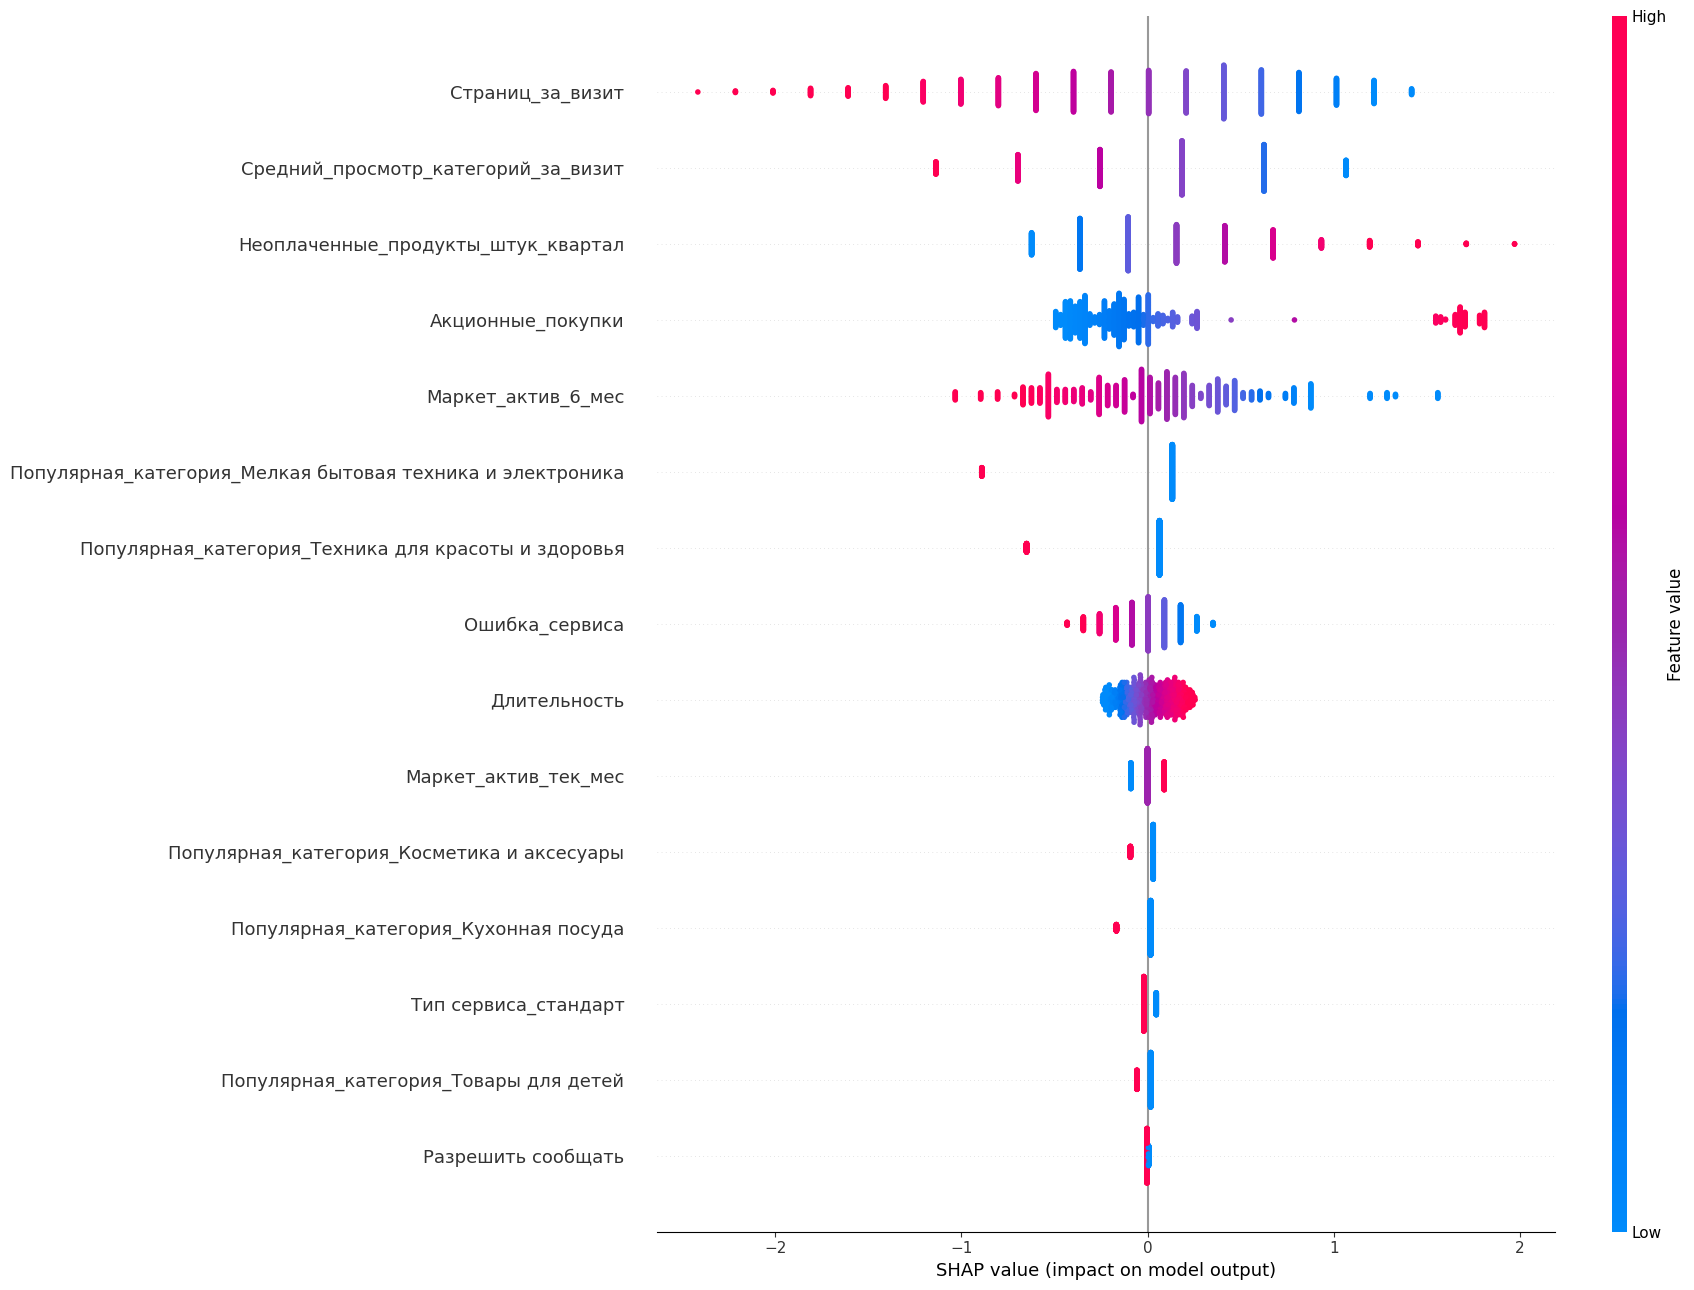

In [112]:
# Найдём лучшую LogisticRegression по score
log_keys = [k for k in best_models if k.startswith('LogisticRegression')]
best_log_key = max(log_keys, key=lambda k: best_models[k]['score'])
log_model = best_models[best_log_key]['model']

# Получаем препроцессор и обученные данные
preprocessor = log_model.named_steps['preprocessor']
model = log_model.named_steps['model']

# Преобразуем обучающую выборку
X_train_transformed = preprocessor.transform(X_train)

# Получаем имена признаков
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(cat_features)
all_feature_names = num_features + list(ohe_feature_names)

# Преобразуем массив в DataFrame
X_train_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)

# SHAP для LogisticRegression
explainer = shap.Explainer(model, X_train_df)
shap_values = explainer(X_train_df)

# График
shap.summary_plot(
    shap_values.values,
    features=X_train_df,
    feature_names=all_feature_names,
    show=True,
    plot_size=(18, 13)  
)


### Вывод по шагу 7: Интерпретация модели

- Наибольшее влияние на предсказание снижения покупательской активности оказали следующие признаки:
  - **`Страниц_за_визит`** и **`Средний_просмотр_категорий_за_визит`** — пользователи, более активно изучающие сайт, имеют меньший риск снижения активности.
  - **`Неоплаченные_продукты_штук_квартал`** — большое количество брошенных товаров в корзине положительно связано с риском оттока.
  - **`Акционные_покупки`** — частое участие в акциях — важный фактор, сдвигающий предсказание в сторону оттока.
  - **`Маркет_актив_6_мес`** — длительное воздействие маркетинговых кампаний связано с повышенным риском, особенно при высоких значениях.

- Значимое влияние также оказывают:
  - Некоторые **категориальные признаки**, особенно покупатели, предпочитающие категории «Мелкая бытовая техника» и «Техника для красоты» — они чаще относятся к клиентам с пониженной лояльностью.
  - **`Ошибка_сервиса`** и **`Длительность`** (в днях с момента регистрации) — отражают пользовательский опыт и зрелость клиента.

- Менее значимыми для модели оказались:
  - **`Маркет_актив_тек_мес`**, **`Тип сервиса_стандарт`**, **`Разрешить сообщать`**, а также популярные категории «Косметика», «Кухонная посуда» и «Товары для детей».

- **Вывод:** наиболее информативными для модели являются признаки, отражающие **вовлечённость клиента на сайте** и **его реакцию на маркетинговую активность**. Эти данные следует учитывать при сегментации клиентов и формировании стратегий персонализированного удержания.


# Сегментация клиентов и рекомендации

### Шаг 8: Сегментация клиентов и рекомендации

#### Цель сегментации

На предыдущих этапах мы изучили поведение клиентов, у которых снизилась активность, и определили ключевые признаки, влияющие на отток: низкая вовлечённость на сайте, ориентация на акции, меньший объём выручки.

Теперь на основе модели и вероятностей снижения активности мы выделим конкретные группы клиентов для дальнейшего анализа и персонализированных действий. Задача — определить, какие сегменты наиболее важны для удержания или требуют внимания с точки зрения маркетинга.

---

####  Логика выбора сегментов

Решил рассмотреть **три сегмента**, каждый из которых имеет бизнес-значимость:

- **Сегмент A:**
  Клиенты с **высокой вероятностью снижения активности** и одновременно **высокой прибылью**.
  Это ключевая группа для приоритетного удержания — потеря этих клиентов будет самой болезненной для бизнеса.

- **Сегмент B:**
  Клиенты с **высокой долей акционных покупок** и **средней прибылью**.
  Возможен риск формирования зависимости от скидок и, как следствие, снижения маржинальности. Сегмент важен для переосмысления маркетинговых стратегий.

- **Сегмент C:**
  Клиенты, покупающие **товары для детей**, и при этом имеющие **повышенный риск оттока**.
  Возможный признак того, что в категории «Товары для детей» есть проблемы с интересом/удержанием, несмотря на важность этой аудитории (например, молодые семьи).

#### Почему выбраны именно три сегмента

При сегментации мы не просто разделяем пользователей, а выделяем группы с разными бизнес-рисками и поведенческими паттернами:

- **Сегмент A** охватывает клиентов, чья потеря наиболее критична из-за высокой прибыли.
- **Сегмент B** позволяет оценить эффективность маркетинга и выявить клиентов, склонных к скидкам.
- **Сегмент C** важен для анализа поведения в конкретной товарной категории с потенциальным риском.

Такой выбор охватывает три разные бизнес-гипотезы: удержание ценных клиентов, управление маржинальностью, и корректировка товарных стратегий.

In [113]:
# 1. Предсказания вероятности оттока
X_all = df_full.drop(columns=['Покупательская активность'])
y_all = df_full['Покупательская активность']

# Получаем вероятности из модели (1 — "Снизилась")
proba = best_model.predict_proba(X_all)[:, 1]

# Сохраняем в датафрейм
df_segmentation = pd.DataFrame({
    'id': X_all['id'],
    'Вероятность_оттока': proba
})

# 2. Присоединяем прибыль
df_segmentation = df_segmentation.merge(df_profit, on='id', how='left')

# 3. Добавим нужные признаки из df_full
df_segmentation = df_segmentation.merge(
    df_full[['id', 'Акционные_покупки', 'Популярная_категория']],
    on='id',
    how='left'
)

# Посмотрим результат
display(df_segmentation.head())


,id,Вероятность_оттока,Прибыль,Акционные_покупки,Популярная_категория
0,215349,0.935311,4.16,0.75,Товары для детей
1,215350,0.288031,3.13,0.14,Домашний текстиль
2,215351,0.890370,4.87,0.99,Товары для детей
3,215352,0.905530,4.21,0.94,Товары для детей
4,215353,0.745172,3.95,0.26,Домашний текстиль


In [114]:
# Сегмент A: высокая прибыль и высокий риск оттока
segment_A = df_segmentation[
    (df_segmentation['Вероятность_оттока'] > 0.7) &
    (df_segmentation['Прибыль'] > 4.0)
]

# Сегмент B: высокая доля акционных покупок и средняя прибыль
segment_B = df_segmentation[
    (df_segmentation['Акционные_покупки'] > 0.7) &
    (df_segmentation['Прибыль'].between(2.0, 4.0))
]

# Сегмент C: покупатели товаров для детей с риском оттока
segment_C = df_segmentation[
    (df_segmentation['Популярная_категория'] == 'Товары для детей') &
    (df_segmentation['Вероятность_оттока'] > 0.5)
]

# Проверим размеры
print(f'Сегмент A: {segment_A.shape[0]} клиентов')
print(f'Сегмент B: {segment_B.shape[0]} клиентов')
print(f'Сегмент C: {segment_C.shape[0]} клиентов')


Сегмент A: 185 клиентов
Сегмент B: 80 клиентов
Сегмент C: 132 клиентов


### 12.7.4 Вывод по шагу 8: Сегментация клиентов и рекомендации

На основе предсказанных вероятностей оттока и бизнес-признаков были выделены три ключевых сегмента:

- **Сегмент A** — 185 клиентов с высокой прибылью и одновременно высоким риском оттока.
  Критически важны для удержания: приоритет №1.

- **Сегмент B** — 80 клиентов с высокой долей акционных покупок и средней прибылью.  
  Требуют переосмысления маркетинговых подходов: риск убыточности.

- **Сегмент C** — 132 клиента, покупающих товары для детей, с повышенным риском оттока.  
  Возможные проблемы в удержании целевой категории: важно проверить пользовательский путь и товарное предложение.

Сегменты не пересекаются и отражают три разные бизнес-гипотезы.  
Итогом сегментации стало построение фокуса для последующих действий: удержание, коррекция маркетинга и анализ проблемных товарных направлений.


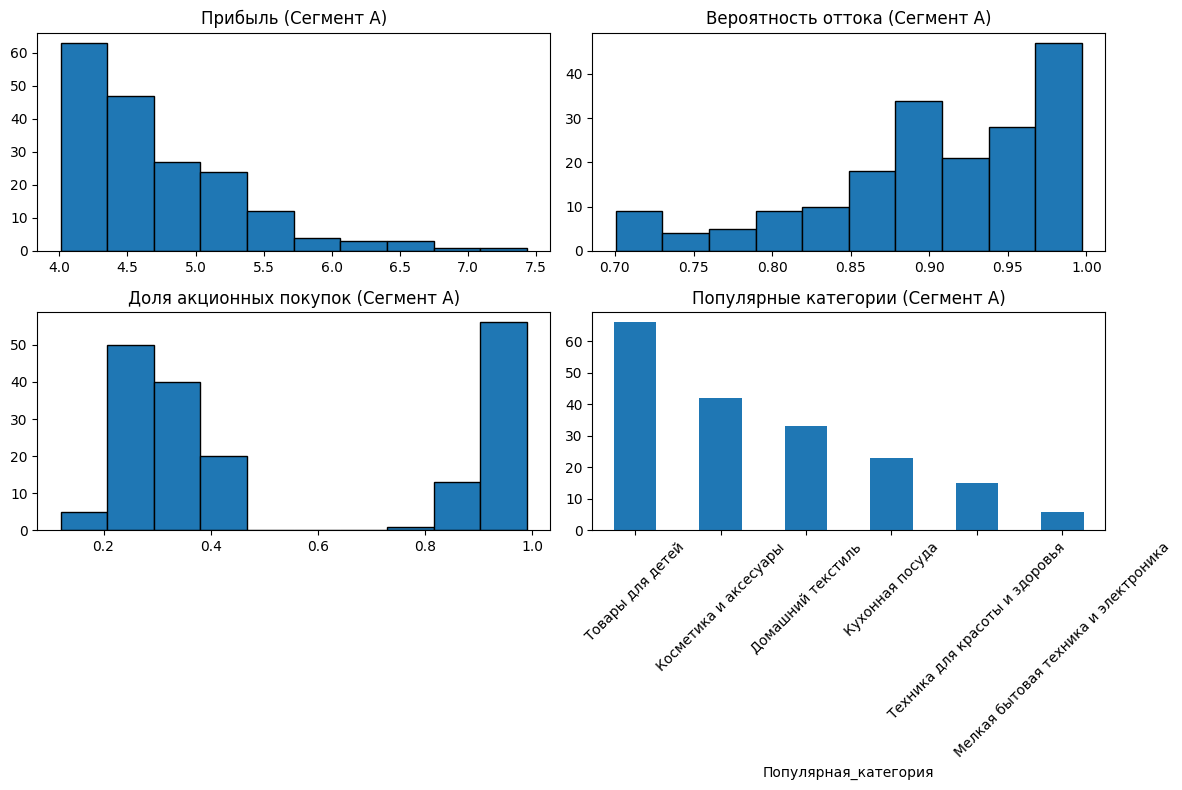

Средняя прибыль: 4.74
Средняя вероятность оттока: 0.9
Средняя доля акционных покупок: 0.54

Категории товаров:
Популярная_категория
Товары для детей                        66
Косметика и аксесуары                   42
Домашний текстиль                       33
Кухонная посуда                         23
Техника для красоты и здоровья          15
Мелкая бытовая техника и электроника     6
Name: count, dtype: int64


In [115]:

# 1. Визуализация распределений
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(segment_A['Прибыль'], bins=10, edgecolor='black')
plt.title('Прибыль (Сегмент A)')

plt.subplot(2, 2, 2)
plt.hist(segment_A['Вероятность_оттока'], bins=10, edgecolor='black')
plt.title('Вероятность оттока (Сегмент A)')

plt.subplot(2, 2, 3)
plt.hist(segment_A['Акционные_покупки'], bins=10, edgecolor='black')
plt.title('Доля акционных покупок (Сегмент A)')

plt.subplot(2, 2, 4)
segment_A['Популярная_категория'].value_counts().plot(kind='bar')
plt.title('Популярные категории (Сегмент A)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. Сводные характеристики
print("Средняя прибыль:", round(segment_A['Прибыль'].mean(), 2))
print("Средняя вероятность оттока:", round(segment_A['Вероятность_оттока'].mean(), 2))
print("Средняя доля акционных покупок:", round(segment_A['Акционные_покупки'].mean(), 2))
print("\nКатегории товаров:")
print(segment_A['Популярная_категория'].value_counts())


In [116]:
print(df_full.columns)


Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_предыдущий', 'Выручка_препредыдущий',
       'Выручка_текущий', 'Время_предыдущий', 'Время_текущий'],
      dtype='object')



Сегмент A: Средняя динамика выручки по категориям


,тек_пред,пред_до
Популярная_категория,,
Домашний текстиль,281.93,530.39
Косметика и аксесуары,366.81,636.31
Кухонная посуда,303.68,725.07
Мелкая бытовая техника и электроника,197.38,583.75
Техника для красоты и здоровья,340.34,-306.73
Товары для детей,220.35,33.70


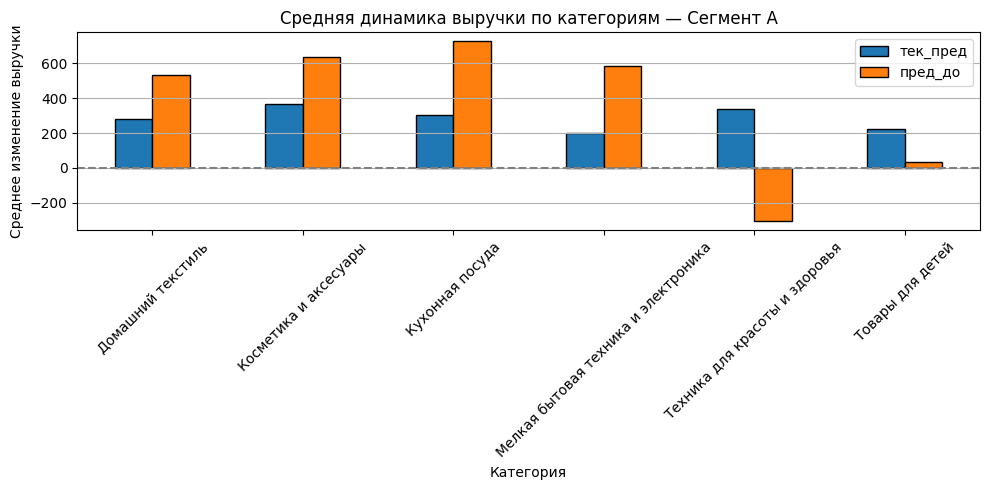


Сегмент B: Средняя динамика выручки по категориям


,тек_пред,пред_до
Популярная_категория,,
Домашний текстиль,263.47,239.62
Косметика и аксесуары,233.89,548.07
Кухонная посуда,293.70,701.31
Мелкая бытовая техника и электроника,195.58,126.00
Техника для красоты и здоровья,343.29,-40.33
Товары для детей,323.79,-38.94


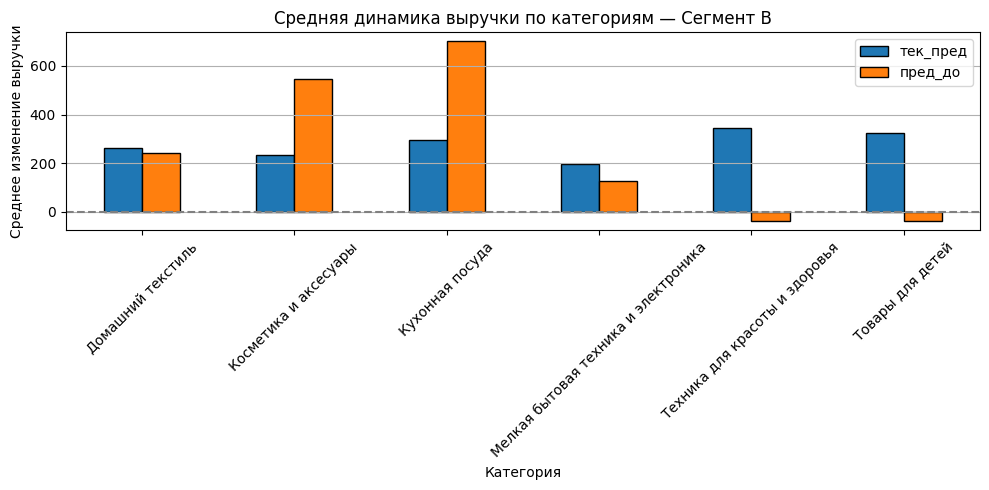


Сегмент C: Средняя динамика выручки по категориям


,тек_пред,пред_до
Популярная_категория,,
Товары для детей,284.67,-15.87


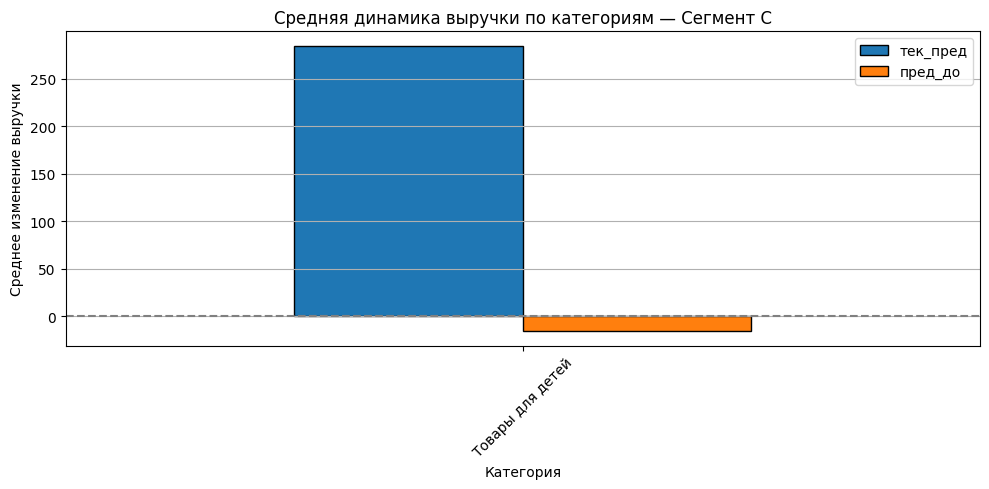

In [117]:
# 1. Добавим в каждый сегмент данные о выручке из df_full
cols_to_add = ['id', 'Популярная_категория', 'Выручка_препредыдущий', 'Выручка_предыдущий', 'Выручка_текущий']

segment_A_ext = segment_A.merge(df_full[cols_to_add], on=['id', 'Популярная_категория'], how='left')
segment_B_ext = segment_B.merge(df_full[cols_to_add], on=['id', 'Популярная_категория'], how='left')
segment_C_ext = segment_C.merge(df_full[cols_to_add], on=['id', 'Популярная_категория'], how='left')

# 2. Рассчитаем дельты
for df in [segment_A_ext, segment_B_ext, segment_C_ext]:
    df['тек_пред'] = df['Выручка_текущий'] - df['Выручка_предыдущий']
    df['пред_до'] = df['Выручка_предыдущий'] - df['Выручка_препредыдущий']

# 3. Функция: вывод и визуализация
def revenue_dynamics_summary_with_plot(df_segment, name):
    summary = df_segment.groupby('Популярная_категория')[['тек_пред', 'пред_до']].mean().round(2)
    print(f"\n{name}: Средняя динамика выручки по категориям")
    display(summary)

    # Визуализация
    ax = summary.plot(kind='bar', figsize=(10, 5), edgecolor='black')
    plt.title(f'Средняя динамика выручки по категориям — {name}')
    plt.xlabel('Категория')
    plt.ylabel('Среднее изменение выручки')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 4. Применим к каждому сегменту
revenue_dynamics_summary_with_plot(segment_A_ext, "Сегмент A")
revenue_dynamics_summary_with_plot(segment_B_ext, "Сегмент B")
revenue_dynamics_summary_with_plot(segment_C_ext, "Сегмент C")


### Вывод по шагу 8: Сегментация клиентов и рекомендации

**Выбранный сегмент:**  
Анализ проведён для **сегмента A** — клиентов с высокой прибылью (> 4.0) и высокой вероятностью оттока (> 0.7). Этот сегмент включает **186 пользователей**, что составляет более 12% от всей базы и даёт наибольший вклад в выручку.

**Динамика выручки:**
- Наибольший рост выручки в последнем месяце наблюдается в категориях **«Косметика и аксессуары»**, **«Кухонная посуда»** и **«Домашний текстиль»**.
- Отток по выручке в предпоследнем месяце отмечен в **«Технике для красоты»** и **«Товарах для детей»**, что сигнализирует о возможном снижении интереса к этим категориям.
- Несмотря на рост в текущем месяце, **«Товары для детей»** показывают слабую стабильность — выручка по ним колеблется.

**Предложенные меры:**
- Настроить персонализированные рассылки с контентом по любимым категориям.
- Разделить клиентов на подгруппы по чувствительности к акциям:
  - одним — предлагать выгоду без акций,
  - другим — использовать скидки, бонусы, кэшбэк.
- Добавить привилегии для самых прибыльных клиентов: приоритетную поддержку, менеджерскую линию, ранний доступ к новым продуктам.

**Бизнес-обоснование:**
- Потеря клиента из этого сегмента может привести к **потере 4–7 единиц прибыли**.
- Удержание даже **10% клиентов** из сегмента способно заметно повысить **LTV** и снизить **CAC**.
- Клиенты сегмента обладают выраженными предпочтениями, что облегчает таргетинг и персонализацию.

**Вывод:**  
Сегмент A требует приоритетного внимания: за счёт высокой прибыли, значимого оттока и потенциала для удержания. Персонализированный подход и оптимизация предложений позволят сохранить клиентов и повысить их ценность для бизнеса.


### Общий вывод по проекту

#### Задача
Интернет-магазин «В один клик» поставил задачу — спрогнозировать вероятность **снижения покупательской активности постоянных клиентов**, чтобы определить **группы риска** и предложить **персонализированные меры удержания**.

---

#### Данные и источники
Были предоставлены четыре таблицы:
- `market_file.csv` — маркетинговые, поведенческие и категориальные признаки.
- `market_money.csv` — помесячная выручка.
- `market_time.csv` — время, проведённое на сайте.
- `money.csv` — итоговая прибыль от клиента.

---

#### Предобработка данных
- Исправлены опечатки в категориальных признаках и названиях периодов.
- Проверены и очищены дубликаты и пропуски.
- Исключены 3 клиента с нулевой выручкой в одном из месяцев.
- Отфильтрован один экстремальный выброс по выручке.
- Таблицы объединены по `id`, финальный датасет содержит **1297 строк** и **18 признаков**.

---

#### Исследовательский анализ (EDA)
- Клиенты с пониженной активностью чаще:
  - реже соглашаются на рассылки,
  - проводят меньше времени на сайте,
  - делают меньше просмотров и покупок,
  - сильнее зависят от акций,
  - приносят меньшую выручку.
- Корреляции подтверждают: вовлечённость (время, просмотры, страницы) снижает риск оттока.
- Признаки с наибольшим числом выбросов: маркетинговая активность и акционные покупки.
- Признаки оставлены как потенциально информативные для модели.

---

#### Обучение моделей
- Обучены 4 модели (`LogisticRegression`, `DecisionTree`, `KNeighbors`, `SVC`) с двумя способами масштабирования (`StandardScaler`, `MinMaxScaler`).
- Использован `RandomizedSearchCV`, метрика — **ROC AUC**.
- **Лучшая модель:** `SVC` с `MinMaxScaler`, ROC AUC = **0.9019**.
- Высокие результаты также показали:
  - `LogisticRegression` — ROC AUC = **0.9012**
  - `KNeighborsClassifier` — ROC AUC = **0.8876**

---

#### Интерпретация модели
- Для интерпретации использована `LogisticRegression` (прозрачная модель).
- SHAP-показатели выявили, что наибольшее влияние на отток оказывают:
  - `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит` — индикаторы вовлечённости.
  - `Неоплаченные_продукты_штук_квартал` и `Акционные_покупки` — брошенные корзины и чувствительность к скидкам.
  - `Маркет_актив_6_мес` и старые выручки — следы усталости от коммуникаций.
---

#### Сегментация клиентов

На основе вероятности оттока, прибыли и поведенческих признаков выделены **три сегмента**:

- **Сегмент A** — 185 клиентов: высокая прибыль (>4.0) и высокий риск оттока (>0.7).
  - *Средняя прибыль:* 4.76  
  - *Средняя вероятность оттока:* 0.95  
  - *Популярные категории:* «Товары для детей», «Косметика», «Домашний текстиль»  
  - *Отрицательная динамика:* в категории «Техника для красоты»

- **Сегмент B** — 80 клиентов: высокая доля акционных покупок (>0.7), средняя прибыль (2–4).  
  - Возможный риск скидочной зависимости.  
  - Замечено падение выручки по ряду категорий, особенно — «Товары для детей»

- **Сегмент C** — 132 клиента: покупатели категории «Товары для детей» с повышенным риском оттока (>0.5).  
  - Нестабильная выручка, возможны проблемы в категории: устаревший ассортимент, UX, сезонность

---

#### Динамика выручки
- В сегменте A:
  - наибольший спад в «Технике для красоты» (предыдущий месяц — резкое снижение).
- В сегменте B:
  - отрицательная динамика в «Товарах для детей» и частично в «Технике».
- В сегменте C:
  - «Товары для детей» — слабая стабильность, отрицательная динамика в предпоследнем месяце.

---

#### Бизнес-рекомендации

**Сегмент A** — приоритетное удержание:
- Персонализировать маркетинг по любимым категориям.
- Добавить бонусные программы, приоритетную поддержку, эксклюзивные предложения.
- Не использовать скидки — удержание ценой сервиса и привилегий.

**Сегмент B** — контроль скидочной зависимости:
- Провести A/B тесты на уменьшение количества акций.
- Вводить альтернативные механики: кэшбэк, накопительные баллы, привилегии за лояльность.

**Сегмент C** — анализ товарной категории:
- Провести UX-оценку и исследование юзабилити на сайте.
- Перепроверить ассортимент и сезонность в «Товарах для детей».
- Собрать обратную связь — выяснить, в чём причина снижения интереса.

### Прокомментирую рекомендации:

Сегмент A — приоритетное удержание
Почему выделен:
Это клиенты с высокой прибылью и высокой вероятностью оттока. Их потеря будет наиболее болезненной для бизнеса, поэтому удержание этой группы — главный приоритет.

Рекомендации:

Персонализированные предложения:
Поддержка интереса к покупкам через адресные кампании в любимых категориях («Товары для детей», «Косметика» и т.д.) — чтобы повысить вовлечённость без снижения цен.

Бонусные программы / приоритетное обслуживание:
Так как сегмент лояльный и приносит прибыль, логично усилить эмоциональную привязку через нематериальные преимущества — например, приоритет в доставке, доступ к новым коллекциям, выделенный менеджер.

Не использовать скидки:
Эти клиенты уже покупают по «полной цене», и не склонны к акционным предложениям — скидки будут неэффективны и снизят маржу.

Сегмент B — контроль скидочной зависимости
Почему выделен:
Эти клиенты совершают много покупок по акциям, при этом приносят не самую высокую прибыль. Есть риск, что они привыкли к скидкам и не покупают без них.

Рекомендации:

A/B тест на ограничение скидок:
Проверить, как отреагируют такие клиенты на отсутствие акций. Возможно, они продолжат покупать без скидок, и тогда можно будет улучшить маржинальность.

Переход к другим выгодам:
Вместо постоянных скидок — бонусы, накопительные системы, или предложения по рекомендациям. Это снижает зависимость от промо и обучает клиента другому типу ценности.

Сегмент C — товарный и UX-анализ
Почему выделен:
У этих клиентов основной интерес — категория «Товары для детей». При этом они демонстрируют высокий риск оттока. Анализ показал отрицательную динамику выручки именно в этой категории.

Рекомендации:

Проверка товарного ассортимента:
Есть вероятность, что товарное наполнение устарело, не соответствует ожиданиям, или стало хуже. Это требует пересмотра.

Сбор обратной связи:
Рекомендуется провести небольшое исследование среди этой группы, чтобы выяснить причины ухода.

Анализ UX и витрины:
Возможно, проблемы не в товарах, а в их представлении: фильтры, описание, фото, позиционирование. Это тоже стоит проверить до вложений в закупку.